In [1]:
import glob
import json
import re

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import QTable, vstack, join
from astropy.wcs import WCS
from scipy.interpolate import interp1d
from tqdm import tqdm
from tqdm.contrib import tzip

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cluster_id = re.compile(r'SPT-CLJ\d+-\d+')

In [2]:
# Set our selection magnitude ranges
ch1_bright_mag = 10.0  # Bright-end 3.6 um magnitude
ch1_faint_mag = 18.3  # Faint-end 3.6 um magnitude
ch2_bright_mag = 10.45  # Bright-end 4.5 um magnitude
ch2_faint_mag = 17.48  # Faint-end 4.5 um magnitude

# Set our correction factors needed to be able to use IRAC magnitude cuts
w1_correction = -0.11
w2_correction = -0.07

# Set our magnitude binning
mag_bin_width = 0.25
magnitude_bins = np.arange(ch2_bright_mag, ch2_faint_mag, mag_bin_width)
magnitude_bin_centers = magnitude_bins[:-1] + np.diff(magnitude_bins) / 2

In [3]:
# Read in the color threshold--redshift relations
with open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color_4.5_17.48.json', 'r') as f:
    sdwfs_purity_data = json.load(f)
z_bins = sdwfs_purity_data['redshift_bins'][:-1]
agn_purity_color = interp1d(z_bins, sdwfs_purity_data['purity_90_colors'], kind='previous')

# Read in the annulus information that we previously calculated
with open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPTcl-local_bkg_annulus.json', 'r') as f:
    spt_wise_annuli_data = json.load(f)

In [4]:
# Read in the SSDF catalog
ssdf_template = QTable.read('Data_Repository/Project_Data/SPT-IRAGN/SPTPol/catalogs/ssdf_table_template.cat',
                           format='ascii.sextractor')
full_ssdf_irac_gals = QTable.read('Data_Repository/Catalogs/SSDF/SSDF2.20170125.v10.public.cat', format='ascii',
                   names=ssdf_template.colnames)
full_ssdf_irac_gals['I1_MAG_APER4'] = full_ssdf_irac_gals['I1_MAG_APER4'].value
full_ssdf_irac_gals['I2_MAG_APER4'] = full_ssdf_irac_gals['I2_MAG_APER4'].value

In [5]:
# # Read in the SSDF IRAC galaxy catalogs
# ssdf_irac_gals = []
ssdf_irac_fnames = glob.glob('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/catalogs/ssdf_irac/'
                             '*_ssdf-irac_local_bkg.ecsv')
ssdf_spt_ids = [cluster_id.search(name).group(0) for name in ssdf_irac_fnames]
# for ssdf_irac_fname in tqdm(ssdf_irac_fnames, desc='Reading in SSDF IRAC catalogs'):
#     ssdf_irac_gal = QTable.read(ssdf_irac_fname)
# 
#     # Fix magnitude column units
#     for mag_colname in [colname for colname in ssdf_irac_gal.colnames if '_MAG' in colname]:
#         ssdf_irac_gal[mag_colname] = ssdf_irac_gal[mag_colname].value
#     ssdf_irac_gals.append(ssdf_irac_gal)
# ssdf_irac_gals = vstack(ssdf_irac_gals)

In [7]:
# Read in and process the SPT WISE galaxy catalogs
ssdf_wise_gals = []
ssdf_wise_fnames = glob.glob('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/catalogs/*_wise_local_bkg.ecsv')
ssdf_wise_fnames = [wise_fname for wise_fname in ssdf_wise_fnames
                    if any(irac_fname in wise_fname for irac_fname in ssdf_spt_ids)]
for cluster_name, ssdf_wise_fname in tzip(ssdf_spt_ids, ssdf_wise_fnames, desc='Processing SPT WISE Catalogs'):
    ssdf_wise_gal = QTable.read(ssdf_wise_fname)

    # Remove the problematic units on the flux columns
    for flux_colname in [colname for colname in ssdf_wise_gal.colnames if 'flux' in colname]:
        ssdf_wise_gal[flux_colname] = ssdf_wise_gal[flux_colname].value

    # Excise the cluster and only select objects in our chosen annulus
    # spt_wise_gal_cluster_coord = SkyCoord(ssdf_wise_gal['SZ_RA'][0], ssdf_wise_gal['SZ_DEC'][0], unit=u.deg)
    # spt_wise_gal_coords = SkyCoord(ssdf_wise_gal['ra'], ssdf_wise_gal['dec'], unit=u.deg)
    # spt_wise_gal_sep_deg = spt_wise_gal_cluster_coord.separation(spt_wise_gal_coords)
    ssdf_wise_gals.append(ssdf_wise_gal)
ssdf_wise_gals = vstack(ssdf_wise_gals)

Processing SPT WISE Catalogs:   0%|          | 0/74 [00:00<?, ?it/s]

In [8]:
# Select clusters within 0.6 < z <= 0.8
ssdf_wise_gals = ssdf_wise_gals[(0.6 < ssdf_wise_gals['REDSHIFT']) & (ssdf_wise_gals['REDSHIFT'] <= 0.8)]

# Convert the R200 radii to degrees so we can easily do cuts
ssdf_wise_gals['R200_deg'] = ssdf_wise_gals['R200'] * cosmo.arcsec_per_kpc_proper(ssdf_wise_gals['REDSHIFT']).to(u.deg/u.Mpc)

# Compute separations within each cluster
wise_clusters = []
for cluster in ssdf_wise_gals.group_by('SPT_ID').groups:
    center_coord = SkyCoord(cluster['SZ_RA'][0], cluster['SZ_DEC'][0], unit=u.deg)
    coords = SkyCoord(cluster['ra'], cluster['dec'], unit=u.deg)
    
    cluster['cluster_radial_sep'] = center_coord.separation(coords)
    wise_clusters.append(cluster)
ssdf_wise_gals = vstack(wise_clusters)
    

In [9]:
# create versions of the catalog for different radial bins
ssdf_wise_gals_inner_r200 = ssdf_wise_gals[ssdf_wise_gals['cluster_radial_sep'] < ssdf_wise_gals['R200_deg']]
ssdf_wise_gals_1_3r200 = ssdf_wise_gals[(ssdf_wise_gals['R200_deg'] < ssdf_wise_gals['cluster_radial_sep']) & (ssdf_wise_gals['cluster_radial_sep'] <= 3 * ssdf_wise_gals['R200_deg'])]
ssdf_wise_gals_3_5r200 = ssdf_wise_gals[(3 * ssdf_wise_gals['R200_deg'] < ssdf_wise_gals['cluster_radial_sep']) & (ssdf_wise_gals['cluster_radial_sep'] <= 5 * ssdf_wise_gals['R200_deg'])]
ssdf_wise_gals_5_7r200 = ssdf_wise_gals[(5 * ssdf_wise_gals['R200_deg'] < ssdf_wise_gals['cluster_radial_sep']) & (ssdf_wise_gals['cluster_radial_sep'] < 7 * ssdf_wise_gals['R200_deg'])]

In [10]:
# Read in the full SDWFS IRAC galaxy catalog
sdwfs_irac_gal = QTable.read(
    'Data_Repository/Catalogs/Bootes/SDWFS/ch2v33_sdwfs_2009mar3_apcorr_matched_ap4_Main_v0.4.cat.gz',
    format='ascii', names=['ID', 'ALPHA_J2000', 'DELTA_J2000',
                           'B_APFLUX4', 'R_APFLUX4', 'I_APFLUX4',
                           'B_APFLUXERR4', 'R_APFLUXERR4', 'I_APFLUXERR4',
                           'B_APMAG4', 'R_APMAG4', 'I_APMAG4',
                           'B_APMAGERR4', 'R_APMAGERR4', 'I_APMAGERR4',
                           'I1_FLUX_APER4', 'I2_FLUX_APER4', 'I3_FLUX_APER4', 'I4_FLUX_APER4',
                           'I1_FLUXERR_APER4', 'I2_FLUXERR_APER4', 'I3_FLUXERR_APER4', 'I4_FLUXERR_APER4',
                           'I1_FLUX_APER4_BROWN', 'I2_FLUX_APER4_BROWN', 'I3_FLUX_APER4_BROWN',
                           'I4_FLUX_APER4_BROWN',
                           'I1_MAG_APER4', 'I2_MAG_APER4', 'I3_MAG_APER4', 'I4_MAG_APER4',
                           'I1_MAGERR_APER4', 'I2_MAGERR_APER4', 'I3_MAGERR_APER4', 'I4_MAGERR_APER4',
                           'I1_MAGERR_APER4_BROWN', 'I2_MAGERR_APER4_BROWN', 'I3_MAGERR_APER4_BROWN',
                           'I4_MAGERR_APER4_BROWN',
                           'STARS_COLOR', 'STARS_MORPH', 'CLASS_STAR', 'MBZ_FLAG_4_4_4'])
# Read in the SDWFS Photo-z catalog
sdwfs_photo_z_catalog = QTable.read('Data_Repository/Catalogs/Bootes/SDWFS/mbz_v0.06_prior_bri12_18p8.cat.gz',
                                    names=['ID', 'REDSHIFT', 'col3', 'col4', 'col5', 'col6', 'col7'],
                                    format='ascii',
                                    include_names=['ID', 'REDSHIFT'])
# Merge the redshift information into the full catalog
sdwfs_irac_gals = join(sdwfs_irac_gal, sdwfs_photo_z_catalog, keys='ID')

In [11]:
# Read in the SDWFS WISE galaxy catalog
sdwfs_wise_gals = QTable.read('Data_Repository/Catalogs/Bootes/SDWFS/SDWFS_catWISE.ecsv')

# Read in the SDWFS mask image and WCS
sdwfs_mask_img, sdwfs_mask_hdr = fits.getdata('Data_Repository/Project_Data/SPT-IRAGN/Masks/SDWFS/'
                                              'SDWFS_full-field_cov_mask11_11.fits', header=True)
sdwfs_wcs = WCS(sdwfs_mask_hdr)

# Convert the mask image into a boolean mask
sdwfs_mask_img = sdwfs_mask_img.astype(bool)

xy_coords = np.array(sdwfs_wcs.world_to_array_index(SkyCoord(sdwfs_wise_gals['ra'], sdwfs_wise_gals['dec'],
                                                             unit=u.deg)))

# Filter the WISE galaxies using the mask
sdwfs_wise_gals = sdwfs_wise_gals[sdwfs_mask_img[*xy_coords]]

In [12]:
# Correct the photometry on the WISE catalogs to be aligned with the IRAC photometry
ssdf_wise_gals['w1mpro'] += w1_correction * u.mag
ssdf_wise_gals['w2mpro'] += w2_correction * u.mag

sdwfs_wise_gals['w1mpro'] += w1_correction * u.mag
sdwfs_wise_gals['w2mpro'] += w2_correction * u.mag

ssdf_wise_gals_inner_r200['w1mpro'] += w1_correction * u.mag
ssdf_wise_gals_inner_r200['w2mpro'] += w2_correction * u.mag

ssdf_wise_gals_1_3r200['w1mpro'] += w1_correction * u.mag
ssdf_wise_gals_1_3r200['w2mpro'] += w2_correction * u.mag

ssdf_wise_gals_3_5r200['w1mpro'] += w1_correction * u.mag
ssdf_wise_gals_3_5r200['w2mpro'] += w2_correction * u.mag

ssdf_wise_gals_5_7r200['w1mpro'] += w1_correction * u.mag
ssdf_wise_gals_5_7r200['w2mpro'] += w2_correction * u.mag

In [13]:
# Apply the magnitude cuts to all four catalogs
# ssdf_irac_gals = ssdf_irac_gals[(ch1_bright_mag < ssdf_irac_gals['I1_MAG_APER4']) &
#                                 (ssdf_irac_gals['I1_MAG_APER4'] <= ch1_faint_mag) &
#                                 (ch2_bright_mag < ssdf_irac_gals['I2_MAG_APER4']) &
#                                 (ssdf_irac_gals['I2_MAG_APER4'] <= ch2_faint_mag)]
ssdf_wise_gals = ssdf_wise_gals[(ch1_bright_mag < ssdf_wise_gals['w1mpro'].value) &
                                (ssdf_wise_gals['w1mpro'].value <= ch1_faint_mag) &
                                (ch2_bright_mag < ssdf_wise_gals['w2mpro'].value) &
                                (ssdf_wise_gals['w2mpro'].value <= ch2_faint_mag)]
sdwfs_irac_gals = sdwfs_irac_gals[(ch1_bright_mag < sdwfs_irac_gals['I1_MAG_APER4']) &
                                  (sdwfs_irac_gals['I1_MAG_APER4'] <= ch1_faint_mag) &
                                  (ch2_bright_mag < sdwfs_irac_gals['I2_MAG_APER4']) &
                                  (sdwfs_irac_gals['I2_MAG_APER4'] <= ch2_faint_mag)]
sdwfs_wise_gals = sdwfs_wise_gals[(ch1_bright_mag < sdwfs_wise_gals['w1mpro'].value) &
                                  (sdwfs_wise_gals['w1mpro'].value <= ch1_faint_mag) &
                                  (ch2_bright_mag < sdwfs_wise_gals['w2mpro'].value) &
                                  (sdwfs_wise_gals['w2mpro'].value <= ch2_faint_mag)]

full_ssdf_irac_gals = full_ssdf_irac_gals[(ch1_bright_mag < full_ssdf_irac_gals['I1_MAG_APER4']) &
                                          (full_ssdf_irac_gals['I1_MAG_APER4'] <= ch1_faint_mag) &
                                          (ch2_bright_mag < full_ssdf_irac_gals['I2_MAG_APER4']) &
                                          (full_ssdf_irac_gals['I2_MAG_APER4'] <= ch2_faint_mag)]

ssdf_wise_gals_inner_r200 = ssdf_wise_gals_inner_r200[(ch1_bright_mag < ssdf_wise_gals_inner_r200['w1mpro'].value) &
                                                      (ssdf_wise_gals_inner_r200['w1mpro'].value <= ch1_faint_mag) &
                                                      (ch2_bright_mag < ssdf_wise_gals_inner_r200['w2mpro'].value) &
                                                      (ssdf_wise_gals_inner_r200['w2mpro'].value <= ch2_faint_mag)]
ssdf_wise_gals_1_3r200 = ssdf_wise_gals_1_3r200[(ch1_bright_mag < ssdf_wise_gals_1_3r200['w1mpro'].value) &
                                                      (ssdf_wise_gals_1_3r200['w1mpro'].value <= ch1_faint_mag) &
                                                      (ch2_bright_mag < ssdf_wise_gals_1_3r200['w2mpro'].value) &
                                                      (ssdf_wise_gals_1_3r200['w2mpro'].value <= ch2_faint_mag)]
ssdf_wise_gals_3_5r200 = ssdf_wise_gals_3_5r200[(ch1_bright_mag < ssdf_wise_gals_3_5r200['w1mpro'].value) &
                                                      (ssdf_wise_gals_3_5r200['w1mpro'].value <= ch1_faint_mag) &
                                                      (ch2_bright_mag < ssdf_wise_gals_3_5r200['w2mpro'].value) &
                                                      (ssdf_wise_gals_3_5r200['w2mpro'].value <= ch2_faint_mag)]
ssdf_wise_gals_5_7r200 = ssdf_wise_gals_5_7r200[(ch1_bright_mag < ssdf_wise_gals_5_7r200['w1mpro'].value) &
                                                      (ssdf_wise_gals_5_7r200['w1mpro'].value <= ch1_faint_mag) &
                                                      (ch2_bright_mag < ssdf_wise_gals_5_7r200['w2mpro'].value) &
                                                      (ssdf_wise_gals_5_7r200['w2mpro'].value <= ch2_faint_mag)]


# sdwfs_wise_agn = sdwfs_wise_gals[sdwfs_wise_gals['w1mpro'].value - sdwfs_wise_gals['w2mpro'].value >= agn_purity_color(0.8)]
# sdwfs_irac_agn = sdwfs_irac_gals[sdwfs_irac_gals['I1_MAG_APER4'] - sdwfs_irac_gals['I2_MAG_APER4'] >= agn_purity_color(0.8)]
# ssdf_wise_agn = ssdf_wise_gals[ssdf_wise_gals['w1mpro'].value - ssdf_wise_gals['w2mpro'].value >= agn_purity_color(0.8)]
# ssdf_irac_agn = ssdf_irac_gals[ssdf_irac_gals['I1_MAG_APER4'] - ssdf_irac_gals['I2_MAG_APER4'] >= agn_purity_color(0.8)]

In [14]:
# We will need the total areas for both of the fields used
ssdf_area = np.sum([data['annulus_area'] for data in spt_wise_annuli_data.values()]) * u.deg**2
sdwfs_area = np.count_nonzero(sdwfs_mask_img) * sdwfs_wcs.proj_plane_pixel_area()
full_ssdf_area = 94 * u.deg**2 # Ashby+13

# Calculate our weighting factors
ssdf_dndm_weight = ssdf_area.value * mag_bin_width
sdwfs_dndm_weight = sdwfs_area.value * mag_bin_width
full_ssdf_weight = full_ssdf_area * mag_bin_width

In [20]:
# Calculate the areas for each of the radial versions of th ssdf wise catalog
ssdf_wise_gals_inner_r200_area = np.sum([np.pi * cluster['R200_deg'][0].value**2 for cluster in ssdf_wise_gals_inner_r200.group_by('SPT_ID').groups])
ssdf_wise_gals_1_3r200_area = np.sum([np.pi * (3 * cluster['R200_deg'][0].value**2 - cluster['R200_deg'][0].value**2) for cluster in ssdf_wise_gals_1_3r200.group_by('SPT_ID').groups])
ssdf_wise_gals_3_5r200_area = np.sum([np.pi * (5 * cluster['R200_deg'][0].value**2 - 3 * cluster['R200_deg'][0].value**2) for cluster in ssdf_wise_gals_3_5r200.group_by('SPT_ID').groups])
ssdf_wise_gals_5_7r200_area = np.sum([np.pi * (7 * cluster['R200_deg'][0].value**2 - 5 * cluster['R200_deg'][0].value**2) for cluster in ssdf_wise_gals_5_7r200.group_by('SPT_ID').groups])

# Calculate weighting factors
ssdf_wise_gals_inner_r200_weight = ssdf_wise_gals_inner_r200_area * mag_bin_width
ssdf_wise_gals_1_3r200_weight = ssdf_wise_gals_1_3r200_area * mag_bin_width
ssdf_wise_gals_3_5r200_weight = ssdf_wise_gals_3_5r200_area * mag_bin_width
ssdf_wise_gals_5_7r200_weight = ssdf_wise_gals_5_7r200_area * mag_bin_width

In [28]:
u.Quantity([ssdf_wise_gals_inner_r200_area, ssdf_wise_gals_1_3r200_area, ssdf_wise_gals_3_5r200_area, ssdf_wise_gals_5_7r200_area], unit=u.deg**2).to(u.arcmin**2)

<Quantity [382.45727285, 764.91454569, 764.91454569, 764.91454569] arcmin2>

In [36]:
full_ssdf_irac_agn = full_ssdf_irac_gals[full_ssdf_irac_gals['I1_MAG_APER4'] - full_ssdf_irac_gals['I2_MAG_APER4'] >= agn_purity_color(0.6)]
sdwfs_irac_agn = sdwfs_irac_gals[sdwfs_irac_gals['I1_MAG_APER4'] - sdwfs_irac_gals['I2_MAG_APER4'] >= agn_purity_color(0.6)]

In [37]:
# Compute the histograms
# ssdf_irac_dndm, _ = np.histogram(ssdf_irac_gals['I2_MAG_APER4'], bins=magnitude_bins)
# ssdf_irac_dndm_weighted = ssdf_irac_dndm / ssdf_dndm_weight

ssdf_wise_dndm, _ = np.histogram(ssdf_wise_gals['w2mpro'].value, bins=magnitude_bins)
ssdf_wise_dndm_weighted = ssdf_wise_dndm / ssdf_dndm_weight

sdwfs_irac_dndm, _ = np.histogram(sdwfs_irac_gals['I2_MAG_APER4'], bins=magnitude_bins)
sdwfs_irac_dndm_weighted = sdwfs_irac_dndm / sdwfs_dndm_weight

sdwfs_wise_dndm, _ = np.histogram(sdwfs_wise_gals['w2mpro'].value, bins=magnitude_bins)
sdwfs_wise_dndm_weighted = sdwfs_wise_dndm / sdwfs_dndm_weight

full_ssdf_irac_gals_dndm, _ = np.histogram(full_ssdf_irac_gals['I2_MAG_APER4'], bins=magnitude_bins)
full_ssdf_irac_gals_dndm_weighted = full_ssdf_irac_gals_dndm / full_ssdf_weight

full_ssdf_irac_agn_dndm, _ = np.histogram(full_ssdf_irac_agn['I2_MAG_APER4'], bins=magnitude_bins)
full_ssdf_irac_agn_dndm_weighted = full_ssdf_irac_agn_dndm / full_ssdf_weight

sdwfs_irac_agn_dndm, _ = np.histogram(sdwfs_irac_agn['I2_MAG_APER4'], bins=magnitude_bins)
sdwfs_irac_agn_dndm_weighted = sdwfs_irac_agn_dndm / sdwfs_dndm_weight

# sdwfs_wise_agn_dndm, _ = np.histogram(sdwfs_wise_agn['w2mpro'].value, bins=magnitude_bins)
# sdwfs_wise_agn_dndm_weighted = sdwfs_wise_agn_dndm / sdwfs_dndm_weight
# 
# sdwfs_irac_agn_dndm, _ = np.histogram(sdwfs_irac_agn['I2_MAG_APER4'], bins=magnitude_bins)
# sdwfs_irac_agn_dndm_weighted = sdwfs_irac_agn_dndm / sdwfs_dndm_weight
# 
# ssdf_wise_agn_dndm, _ = np.histogram(ssdf_wise_agn['w2mpro'].value, bins=magnitude_bins)
# ssdf_wise_agn_dndm_weighted = ssdf_wise_agn_dndm / ssdf_dndm_weight
# 
# ssdf_irac_agn_dndm, _ = np.histogram(ssdf_irac_agn['I2_MAG_APER4'], bins=magnitude_bins)
# ssdf_irac_agn_dndm_weighted = ssdf_irac_agn_dndm / ssdf_dndm_weight

ssdf_wise_gals_inner_r200_dndm, _ = np.histogram(ssdf_wise_gals_inner_r200['w2mpro'].value, bins=magnitude_bins)
ssdf_wise_gals_inner_r200_dndm_weighted = ssdf_wise_gals_inner_r200_dndm / ssdf_wise_gals_inner_r200_weight

ssdf_wise_gals_1_3r200_dndm, _ = np.histogram(ssdf_wise_gals_1_3r200['w2mpro'].value, bins=magnitude_bins)
ssdf_wise_gals_1_3r200_dndm_weighted = ssdf_wise_gals_1_3r200_dndm / ssdf_wise_gals_1_3r200_weight

ssdf_wise_gals_3_5r200_dndm, _ = np.histogram(ssdf_wise_gals_3_5r200['w2mpro'].value, bins=magnitude_bins)
ssdf_wise_gals_3_5r200_dndm_weighted = ssdf_wise_gals_3_5r200_dndm / ssdf_wise_gals_3_5r200_weight

ssdf_wise_gals_5_7r200_dndm, _ = np.histogram(ssdf_wise_gals_5_7r200['w2mpro'].value, bins=magnitude_bins)
ssdf_wise_gals_5_7r200_dndm_weighted = ssdf_wise_gals_5_7r200_dndm / ssdf_wise_gals_5_7r200_weight

In [38]:
# Calculate the errors
# ssdf_irac_dndm_err = np.sqrt(ssdf_irac_dndm) / ssdf_dndm_weight
ssdf_wise_dndm_err = np.sqrt(sdwfs_wise_dndm) / ssdf_dndm_weight

sdwfs_irac_dndm_err = np.sqrt(sdwfs_irac_dndm) / sdwfs_dndm_weight
sdwfs_wise_dndm_err = np.sqrt(sdwfs_wise_dndm) / sdwfs_dndm_weight

full_ssdf_irac_gals_dndm_err = np.sqrt(full_ssdf_irac_gals_dndm) / full_ssdf_weight

full_ssdf_irac_agn_dndm_err = np.sqrt(full_ssdf_irac_agn_dndm) / full_ssdf_weight

sdwfs_irac_agn_dndm_err = np.sqrt(sdwfs_irac_agn_dndm) / sdwfs_dndm_weight

# sdwfs_irac_agn_dndm_err = np.sqrt(sdwfs_irac_agn_dndm) / sdwfs_dndm_weight
# sdwfs_wise_agn_dndm_err = np.sqrt(sdwfs_wise_agn_dndm) / sdwfs_dndm_weight
# 
# ssdf_irac_agn_dndm_err = np.sqrt(ssdf_irac_agn_dndm) / ssdf_dndm_weight
# ssdf_wise_agn_dndm_err = np.sqrt(ssdf_wise_agn_dndm) / ssdf_dndm_weight

ssdf_wise_gals_inner_r200_dndm_err = np.sqrt(ssdf_wise_gals_inner_r200_dndm) / ssdf_wise_gals_inner_r200_weight
ssdf_wise_gals_1_3r200_dndm_err = np.sqrt(ssdf_wise_gals_1_3r200_dndm) / ssdf_wise_gals_1_3r200_weight
ssdf_wise_gals_3_5r200_dndm_err = np.sqrt(ssdf_wise_gals_3_5r200_dndm) / ssdf_wise_gals_3_5r200_weight
ssdf_wise_gals_5_7r200_dndm_err = np.sqrt(ssdf_wise_gals_5_7r200_dndm) / ssdf_wise_gals_5_7r200_weight

[Text(0.5, 0, '[4.5] or W2 (Vega)'),
 Text(0, 0.5, '$dN/dm$ [deg$^{-2}$ mag$^{-1}$]'),
 None]

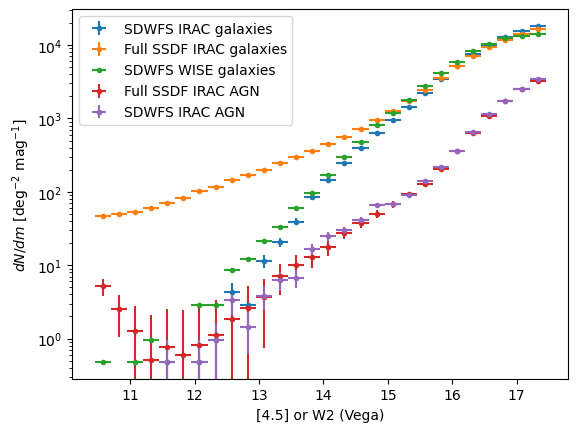

In [39]:
fig, ax = plt.subplots()
ax.errorbar(magnitude_bin_centers, sdwfs_irac_dndm_weighted, yerr=sdwfs_irac_dndm_err, xerr=mag_bin_width/2, fmt='.', label='SDWFS IRAC galaxies')
ax.errorbar(magnitude_bin_centers, full_ssdf_irac_gals_dndm_weighted, yerr=full_ssdf_irac_gals_dndm_err, xerr=mag_bin_width/2, fmt='.', label='Full SSDF IRAC galaxies')
ax.errorbar(magnitude_bin_centers, sdwfs_wise_dndm_weighted, xerr=mag_bin_width/2, fmt='.', label='SDWFS WISE galaxies')
ax.errorbar(magnitude_bin_centers, full_ssdf_irac_agn_dndm_weighted, yerr=full_ssdf_irac_gals_dndm_err, xerr=mag_bin_width/2,
            fmt='.', label='Full SSDF IRAC AGN')

ax.errorbar(magnitude_bin_centers, sdwfs_irac_agn_dndm_weighted, yerr=sdwfs_irac_agn_dndm_err, xerr=mag_bin_width/2,
            fmt='.', label='SDWFS IRAC AGN')
# ax.errorbar(magnitude_bin_centers, ssdf_wise_gals_inner_r200_dndm_weighted, yerr=ssdf_wise_gals_inner_r200_dndm_err, xerr=mag_bin_width/2, fmt='.', label=r'SSDF WISE galaxies $< r_{200}$')
# ax.errorbar(magnitude_bin_centers, ssdf_wise_gals_1_3r200_dndm_weighted, yerr=ssdf_wise_gals_1_3r200_dndm_err, xerr=mag_bin_width/2, fmt='.', label=r'SSDF WISE galaxies $1 < r/r_{200} \leq 3$')
# ax.errorbar(magnitude_bin_centers, ssdf_wise_gals_3_5r200_dndm_weighted, yerr=ssdf_wise_gals_3_5r200_dndm_err, xerr=mag_bin_width/2, fmt='.', label=r'SSDF WISE galaxies $3 < r/r_{200} \leq 5$')
# ax.errorbar(magnitude_bin_centers, ssdf_wise_gals_5_7r200_dndm_weighted, yerr=ssdf_wise_gals_5_7r200_dndm_err, xerr=mag_bin_width/2, fmt='.', label=r'SSDF WISE galaxies $5 < r/r_{200} \leq 7$')
ax.legend()
ax.set(xlabel='[4.5] or W2 (Vega)', ylabel=r'$dN/dm$ [deg$^{-2}$ mag$^{-1}$]', yscale='log')